# Continuous Control

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [25]:
!pip -q install ./python

The environments corresponding to both versions of the environment are already saved in the Workspace and can be accessed at the file paths provided below.  

Please select one of the two options below for loading the environment.

In [26]:
from unityagents import UnityEnvironment
import numpy as np


env = UnityEnvironment(file_name='/data/Reacher_Linux_NoVis/Reacher.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [27]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [28]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [  0.00000000e+00  -4.00000000e+00   0.00000000e+00   1.00000000e+00
  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00  -1.00000000e+01   0.00000000e+00
   1.00000000e+00  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   5.75471878e+00  -1.00000000e+00
   5.55726624e+00   0.00000000e+00   1.00000000e+00   0.00000000e+00
  -1.68164849e-01]


### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 

In [29]:
from ddpg_agent import Agent
from collections import deque
import torch
import matplotlib.pyplot as plt
%matplotlib inline

In [30]:
agent = Agent(state_size, action_size, epsilon=0.98)

cuda:0


In [31]:
agent.actor_local, agent.actor_optimizer

(Actor(
   (fc1): Linear(in_features=33, out_features=400, bias=True)
   (n1): BatchNorm1d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (fc2): Linear(in_features=400, out_features=300, bias=True)
   (fc3): Linear(in_features=300, out_features=4, bias=True)
 ), Adam (
 Parameter Group 0
     amsgrad: False
     betas: (0.9, 0.999)
     eps: 1e-08
     lr: 0.001
     weight_decay: 0
 ))

In [32]:
agent.critic_local, agent.critic_optimizer

(Critic(
   (fcs1): Linear(in_features=33, out_features=400, bias=True)
   (n1): BatchNorm1d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (fc2): Linear(in_features=404, out_features=300, bias=True)
   (fc3): Linear(in_features=300, out_features=1, bias=True)
 ), Adam (
 Parameter Group 0
     amsgrad: False
     betas: (0.9, 0.999)
     eps: 1e-08
     lr: 0.001
     weight_decay: 0
 ))

In [33]:
agent.critic_local.load_state_dict(torch.load("checkpoint_critic.pth"))
agent.actor_local.load_state_dict(torch.load("checkpoint_actor.pth"))

In [34]:
def ddpg(n_episodes=1000, max_episode=1000, print_every=2, n_start=0):
    scores = []
    scores_deque = deque(maxlen=100)
    epsilon_decay = 1e-7 
    if n_start>0:
        print("restarting from previous training. Agent loaded previously")
    for i_episode in range(n_start, n_episodes):
        env_info = env.reset(train_mode=True)[brain_name]     
        states = env_info.vector_observations   
        score = np.zeros(num_agents)
        agent.reset()
        for t in range(1, max_episode+1):
            #Act on emnvironment
            actions = agent.act(states) 
            env_info = env.step(actions)[brain_name]           
            next_states = env_info.vector_observations         
            rewards = env_info.rewards                         
            dones = env_info.local_done

            #Learn from Agent
            for state, action, reward, next_state, done in zip(states, actions, rewards, next_states, dones):
                agent.step(state, action, reward, next_state, done, t, epsilon_decay)  

            #Get scores
            score += rewards                         
            states = next_states                               
            if np.any(dones):
                print("Game Done!")
                break
                
        
        scores_deque.append(np.mean(score))
        scores.append(np.mean(score))
        

        if i_episode % print_every == 0:
            print('\rEpisode {}\tMax Score Last: {:.2f} \tAverage Score Last: {:.2f} \tAverage Last 100: {:.2f}'.format(i_episode,
                                                                                           np.max(score),
                                                                                           np.mean(score),
                                                                                           np.mean(scores_deque)),end="")
            if i_episode % 10 == 0: 
                print('\nCurrent Epsilon: {:.4f}'.format(agent.epsilon))
                torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
                torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')

        if np.mean(scores_deque)>30:
            print('\rProblem at Episode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor_best.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic_best.pth')
            break

    torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
    torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')

    return scores

## Previous Training Episode 0 to 20

Episode 0	Max Score Last: 1.81 	Average Score Last: 0.75 	Average Last 100: 0.75

Current Epsilon: 0.9990

Episode 10	Max Score Last: 14.67 	Average Score Last: 4.74 	Average Last 100: 2.89

Current Epsilon: 0.9890

Episode 20	Max Score Last: 24.73 	Average Score Last: 10.67 	Average Last 100: 5.05

Current Epsilon: 0.9790

In [35]:
scores = ddpg(n_start=21)

restarting from previous training. Agent loaded previously
Episode 30	Max Score Last: 6.65 	Average Score Last: 3.17 	Average Last 100: 3.366
Current Epsilon: 0.9700
Episode 40	Max Score Last: 8.93 	Average Score Last: 5.95 	Average Last 100: 4.351
Current Epsilon: 0.9600
Episode 50	Max Score Last: 14.26 	Average Score Last: 7.77 	Average Last 100: 5.51
Current Epsilon: 0.9500
Episode 60	Max Score Last: 14.88 	Average Score Last: 10.81 	Average Last 100: 6.50
Current Epsilon: 0.9400
Episode 70	Max Score Last: 17.09 	Average Score Last: 11.93 	Average Last 100: 7.45
Current Epsilon: 0.9300
Episode 80	Max Score Last: 25.78 	Average Score Last: 16.69 	Average Last 100: 8.52
Current Epsilon: 0.9200
Episode 90	Max Score Last: 26.03 	Average Score Last: 20.47 	Average Last 100: 9.86
Current Epsilon: 0.9100
Episode 100	Max Score Last: 26.47 	Average Score Last: 21.91 	Average Last 100: 11.28
Current Epsilon: 0.9000
Episode 110	Max Score Last: 31.59 	Average Score Last: 28.18 	Average Last 100

In [37]:
print(0)

0


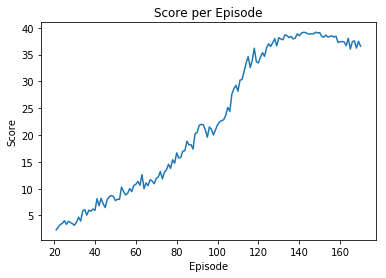

In [38]:
plt.plot(np.arange(21, len(scores)+21), scores)
plt.title('Score per Episode')
plt.ylabel('Score')
plt.xlabel('Episode')
plt.show()